In [2]:
import warnings
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
%matplotlib inline

warnings.filterwarnings('ignore')


ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [ ]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()


In [ ]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'Yen Future Prices'}, xlabel='Date'>

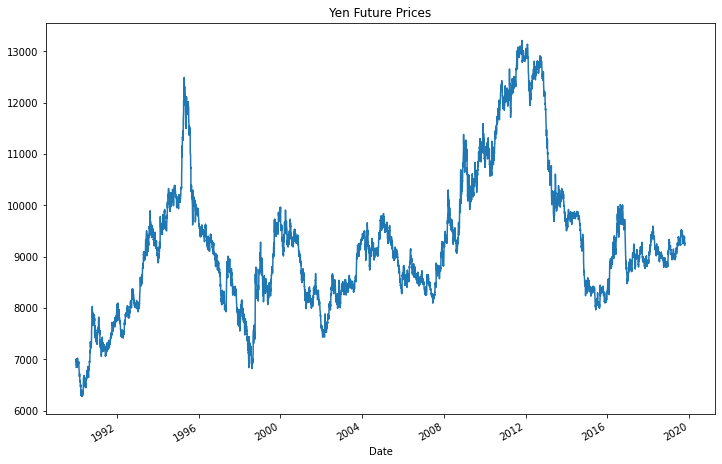

In [17]:
# Plot just the "Settle" column from the dataframe:
yen_futures.Settle.plot(figsize=[12,8], title = "Yen Future Prices")

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [18]:
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])


In [19]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
df_yen_futures = yen_futures[['Settle']].copy()
df_yen_futures['noise'] = ts_noise
df_yen_futures['trend'] = ts_trend

#from above means the latest values
df_yen_futures.tail()


,Settle,noise,trend
Date,,,
2019-10-09,9338.0,24.939247,9313.060753
2019-10-10,9303.5,-5.868559,9309.368559
2019-10-11,9251.0,-54.454594,9305.454594
2019-10-14,9265.0,-36.423060,9301.423060
2019-10-15,9221.5,-75.844123,9297.344123


<AxesSubplot:title={'center':'2015-Present: Settle vs. Trend'}, xlabel='Date'>

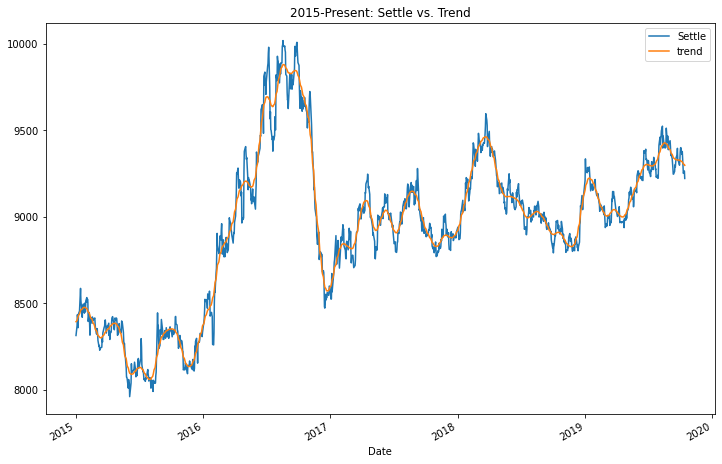

In [20]:
# Plot the Settle Price vs. the Trend for 2015 to the present
current_2015 = df_yen_futures.loc["2015":]
current_2015.plot(y=["Settle", "trend"], figsize=[12,8], title= "2015-Present: Settle vs. Trend")

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

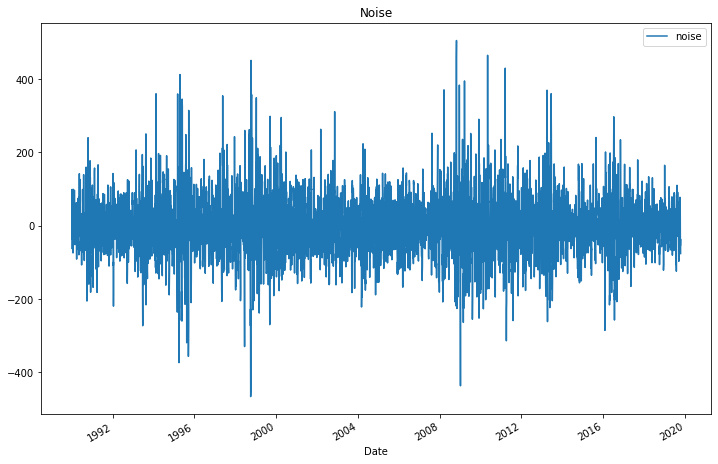

In [21]:
# Plot the Settle Noise
df_yen_futures.plot(y="noise", figsize=[12,8], title = "Noise")

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [22]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [23]:
from statsmodels.tsa.arima_model import ARMA

# Estimate an ARMA model using statsmodels (order=(2, 1))
arma_model = ARMA(returns.Settle, order=(2, 1))

# Fit the model and assign it to a variable called results
result_ARMA = arma_model.fit()


NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [ ]:
# Output model summary results:
result_ARMA.summary()

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

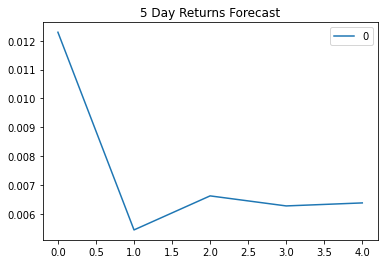

In [ ]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(result_ARMA.forecast(steps=5)[0]).plot(
    title="5 Day Returns Forecast")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [27]:
from statsmodels.tsa.arima.model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!
model_ARIMA = ARIMA(yen_futures["Settle"], order=(5, 1, 1))
# Fit the model
result_ARIMA = model_ARIMA.fit()


In [28]:
# Output model summary results:
summ_ARIMA = model_ARIMA.fit().summary()

In [ ]:
# Plot the 5 Day Price Forecast
pd.DataFrame(summ_ARIMA.forecast(steps=5)[0]).plot(
    title="5 Day Returns Forecast")


---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [34]:
import arch 
from arch import arch_model

In [35]:
# Estimate a GARCH model:
model_GARCH = arch_model(returns.Settle, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
results_GARCH = model_GARCH.fit(disp="off")

In [36]:
# Summarize the model results
results_GARCH.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Sun, Nov 21 2021   Df Residuals:                     7514
Time:                        00:05:23   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.707e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [37]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [38]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = results_GARCH.forecast(start=last_day, horizon=forecast_horizon)

In [39]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434032,7.475729,7.516851,7.55741,7.597418


In [40]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434032
h.2,7.475729
h.3,7.516851
h.4,7.557410
h.5,7.597418


<AxesSubplot:title={'center':'5 Day Forecast of Volatility'}>

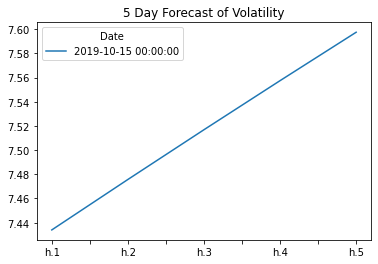

In [41]:
# Plot the final forecast
final.plot(title="5 Day Forecast of Volatility")

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

ANSWERS

1) Medium-to-risky investors should expect to buy the yen now, according to the provided data and analysis.
2) The YEN risk (volatility) is expected to increase along with the price.
3)  yes, the ARIMA and GARCH model proved to be very helpful for time series analysis.